# Uncomment this cell to install the Sentiment analysis required libraries

!pip install nltk
!pip install regex
!pip install wordcloud
!pip install scikit-learn

# Uncomment this cell to Check if the required libraries are successfully installed
import nltk
from nltk.tokenize import punkt
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
import re

In [30]:
#BASIC LIBRARIES
import pandas as pd 
import numpy as np   

import matplotlib.pyplot as plt 
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [31]:
#Importing the dataset
tweets = pd.read_csv('tweets3.csv')
tweets.head()

,Unnamed: 0,message,label
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,288,@lapcat Need to send 'em to my accountant tomo...,0
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


In [32]:
#The unnamed column represents the serial arrangement of instances and it might be unnecessary
#So, lets remove it from the dataset

tweets.drop(['Unnamed: 0'], axis = 1, inplace = True)

tweets.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10314 entries, 0 to 10313
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  10314 non-null  object
 1   label    10314 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 161.3+ KB


## Exploratory Data Analysis and Feature Extraction


#### Checking the distribution of targets to see the number of depressive and non depressive tweets in the dataset

In [33]:
neutral = tweets[tweets['label']==0]
depression = tweets[tweets['label']==1]
print('Depression Tweets: ',len(depression))
print('Neutral Tweets: ', len(neutral))
print('Total Tweets: ', tweets.shape[0])


lb = ['Neutral Tweets(0)', 'Depression Tweets(1)']

Depression Tweets:  2314
Neutral Tweets:  8000
Total Tweets:  10314


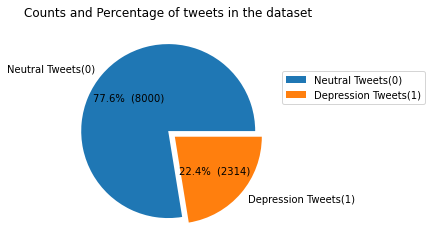

In [34]:
#Visualize the values above

#Function to plot pie chart with specific format
def make_autopct(sizes):
    def my_autopct(pct):
        total = sum(sizes)
        val = int(round(pct*total/100.0))
        return '{p:.1f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct



explode = (0,0.1)
fig1,ax1 = plt.subplots()
sizes = list((len(neutral), len(depression)))

plt.pie(sizes, labels=lb, explode = explode, autopct=make_autopct(sizes))
plt.title('Counts and Percentage of tweets in the dataset')
ax1.legend(loc='best',bbox_to_anchor=(1,0.8))
plt.show()

The data is not well balanced, and depression tweets has the least number of data entries with 2,314, and the neutral tweets has the most data with 8,000 entries. 


#### Preprocessing the messages in the tweet dataset
##### The messages must be parsed to split messages and remove words, called tokenization. Then unnecessary words such as stop words and symbols need to be removed.

In [35]:
#Count of words in each message
import string
def word_counts(sentence):
    return len(sentence)
tweets['word counts'] = tweets['message'].apply(word_counts)

#Estimate the percentage of punctuation marks in each tweet
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

tweets['punct%'] = tweets['message'].apply(lambda x: count_punct(x))

tweets.head()


,message,label,word counts,punct%
0,just had a real good moment. i missssssssss hi...,0,57,4.3
1,is reading manga http://plurk.com/p/mzp1e,0,42,15.8
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0,84,18.8
3,@lapcat Need to send 'em to my accountant tomo...,0,135,7.1
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0,45,12.5


## Pre-processing the data for the training: 
- Tokenization
- Stemming
- Removal of stop words

In [36]:
# Defining a function to remove stop words, urls and symbols etc.

import nltk
import re, string
from bs4 import BeautifulSoup
from string import punctuation
import nltk
#nltk.download('punkt')
from nltk.tokenize import punkt
from nltk.tokenize import word_tokenize
from nltk import sent_tokenize
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer


def gettext(message):
    text = BeautifulSoup(message, 'html.parser')
    return text.get_text()

def removehurls(message):
    return re.sub(r'http\S+', '', message)

def removesymbols(message):
    re.sub(r'^\x00-\x7F+', '', message)
    return re.sub('[@!.,\/&)?:#...-'']', '', message)

def removestopwords(message):
    new_message = []
    message = message.lower()
    message = word_tokenize(message)
    sw = stopwords.words('english')
    for msg in message:
        if msg not in sw:
            new_message.append(msg) 
    return ' '.join(new_message)

def preparemessage(message):
    message = gettext(message)
    message = removehurls(message)
    message = removesymbols(message)
    message = removestopwords(message)
    return message

In [37]:
# removing stop words, urls and symbols etc from the messages.

tweets['messagenew'] = tweets['message'].apply(preparemessage)
tweets['word countsnew'] = tweets['messagenew'].apply(word_counts)
tweets

,message,label,word counts,punct%,messagenew,word countsnew
0,just had a real good moment. i missssssssss hi...,0,57,4.3,real good moment missssssssss much,34
1,is reading manga http://plurk.com/p/mzp1e,0,42,15.8,reading manga,13
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0,84,18.8,comeagainjen,12
3,@lapcat Need to send 'em to my accountant tomo...,0,135,7.1,lapcat need send 'em accountant tomorrow oddly...,98
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0,45,12.5,add myspace myspacecomlookthunder,33
...,...,...,...,...,...,...
10309,No Depression by G Herbo is my mood from now o...,1,101,3.7,depression g herbo mood 'm done stressing peop...,60
10310,What do you do when depression succumbs the br...,1,97,2.5,depression succumbs brain makes feel like 'll ...,58
10311,Ketamine Nasal Spray Shows Promise Against Dep...,1,96,8.0,ketamine nasal spray shows promise depression ...,60
10312,dont mistake a bad day with depression! everyo...,1,57,6.2,dont mistake bad day depression everyone 'em,44


## Wordcloud Analysis

In [38]:
from matplotlib.pyplot import imread

# mask = imread('br1.png')
from PIL import Image
mask1 = np.array(Image.open("Outputs/br5.png"))

In [39]:
def transform_format(val):
    if val == 0:
        return 255
    else:
        return val
    
def transform_image(mask):
    # Transform your mask into a new one that will work with the function:
    transformed_mask = np.ndarray((mask.shape[0],mask.shape[1]), np.int32)

    for i in range(len(mask)):
        transformed_mask[i] = list(map(transform_format, mask[i]))
    return transformed_mask

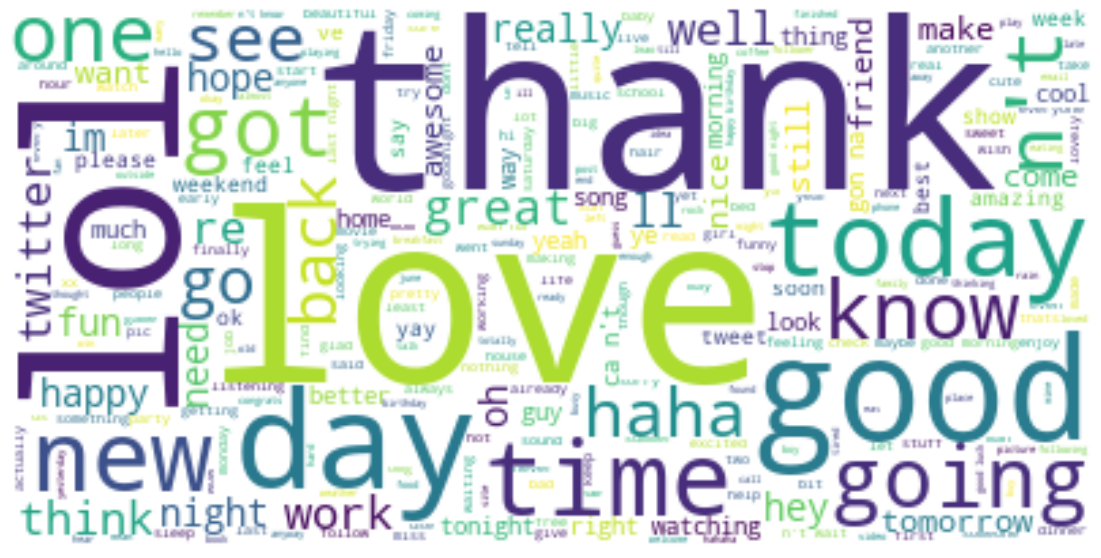

In [40]:
# View of overtly mentioned non-depressive words using Wordcloud

#To do this, we need WORDCLOUD Library
from wordcloud import WordCloud, STOPWORDS


# Create a word cloud image
wc = WordCloud(background_color="white", max_words=1000, 
               stopwords=STOPWORDS, contour_width=3, contour_color='black')

neutral_words = ' '.join(list(tweets[tweets['label'] == 0]['messagenew']))
# Generate a wordcloud
wc.generate(neutral_words)

# store to file
# wc.to_file("Outputs/Dep_worda.png")

# show
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()


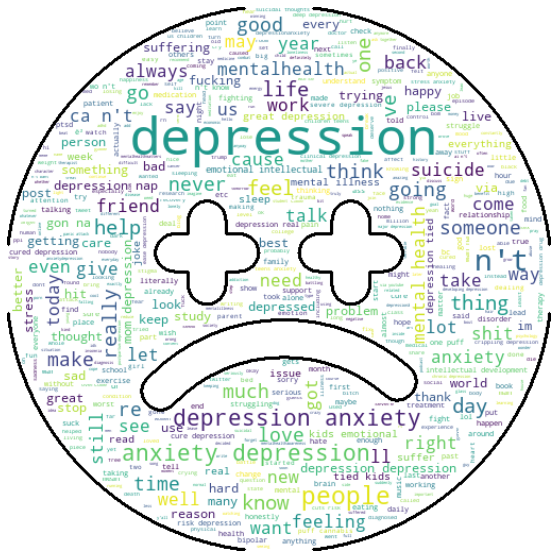

In [41]:
# View of overtly mentioned depressive words using Wordcloud

#To do this, we need WORDCLOUD Library
from wordcloud import WordCloud, STOPWORDS

# Create a word cloud image
wc = WordCloud(background_color="white", max_words=1000, mask=transform_image(mask1),
               stopwords=STOPWORDS, contour_width=3, contour_color='black')

depressive_words = ' '.join(list(tweets[tweets['label'] == 1]['messagenew']))
# Generate a wordcloud
wc.generate(depressive_words)

# store to file
# wc.to_file("img/Dep_worda.png")

# show
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()


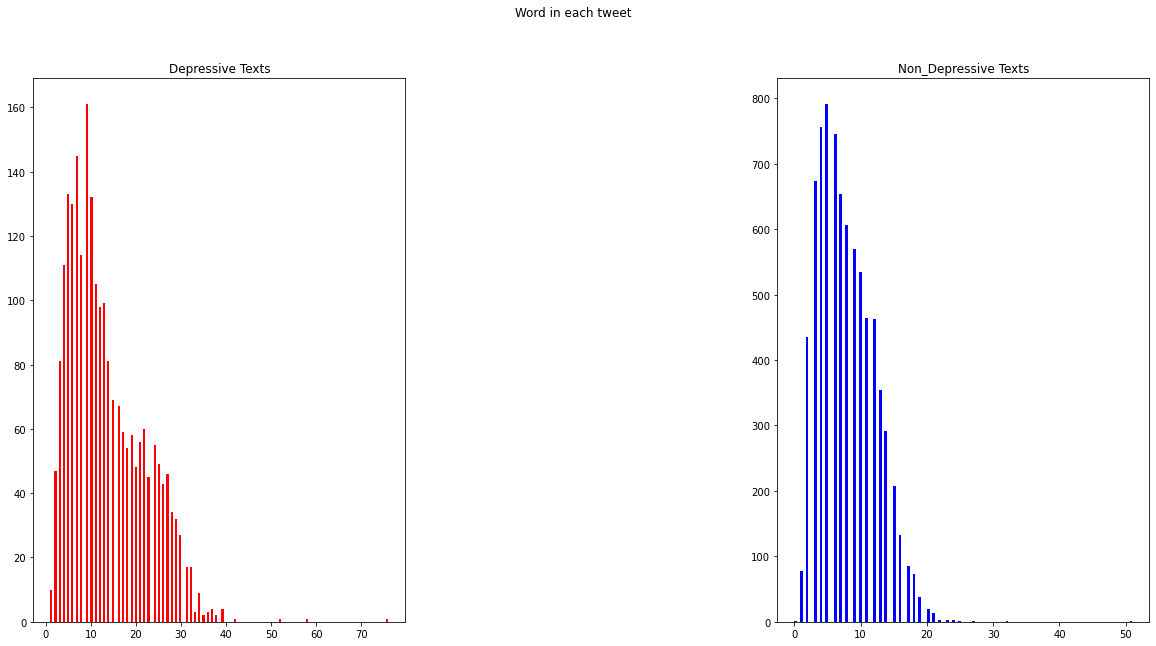

In [42]:
#Word length for each text in both depressive and non depressive message

import seaborn as sns

fig,(ax1, ax2) = plt.subplots(1,2,figsize = (20,10))
fig.suptitle('Word in each tweet')

wordlen = tweets[tweets['label'] == 1]['messagenew'].str.split().map(lambda x : len(x))
ax1.hist(wordlen, bins = 160, color = 'red')
plt.subplots_adjust(wspace=1.0)
ax1.set_title('Depressive Texts')

wordlen = tweets[tweets['label'] == 0]['messagenew'].str.split().map(lambda x : len(x))
ax2.hist(wordlen, bins = 120, color = 'blue')
ax2.set_title('Non_Depressive Texts')

plt.show()

## Unigram Analysis

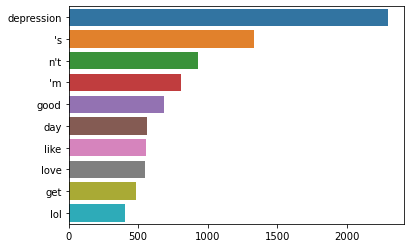

In [43]:
def get_corpus(message):
    words = []
    for i in message:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(tweets.messagenew)



#Unigram Analysis with counter
from collections import Counter
counter = Counter(corpus)
frequent_word = counter.most_common(10)
frequent_word = dict(frequent_word)
sns.barplot(x=list(frequent_word.values()),y=list(frequent_word.keys()))

- 's
- n't
- 'm 

are captured since an ordinary frquency count is used. Lets use standard Vectorizer to obtain the unigram

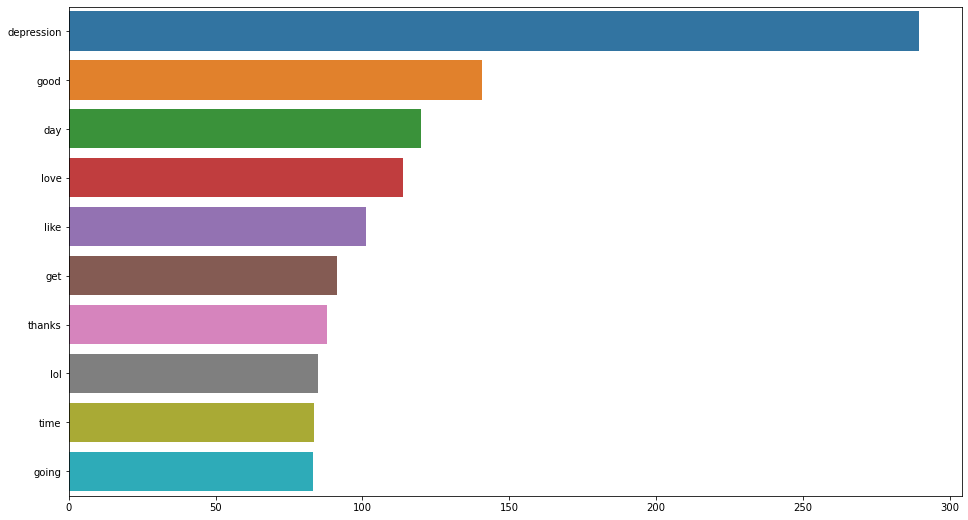

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer

def get_top_text_ngrams(corpus, n, g):
    vec = TfidfVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
plt.figure(figsize = (16,9))
frequent_words = get_top_text_ngrams(tweets.messagenew,10,1)
frequent_words = dict(frequent_words)
sns.barplot(x=list(frequent_words.values()),y=list(frequent_words.keys()))

## Bigram Analysis

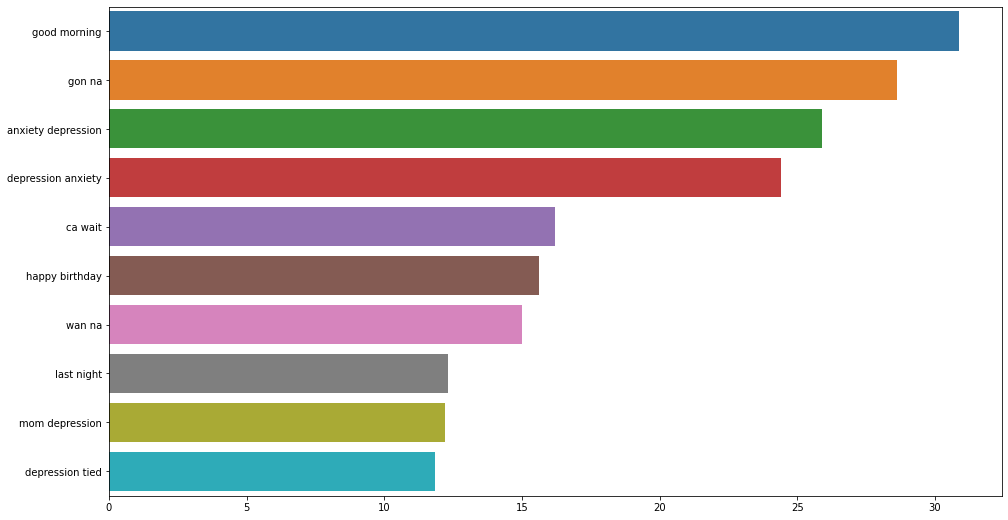

In [45]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def get_top_text_ngrams(corpus, n, g):
    vec = TfidfVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
plt.figure(figsize = (16,9))
frequent_word_bi = get_top_text_ngrams(tweets.messagenew,10,2)
frequent_word_bi = dict(frequent_word_bi)
sns.barplot(x=list(frequent_word_bi.values()),y=list(frequent_word_bi.keys()))

## Trigram Analysis

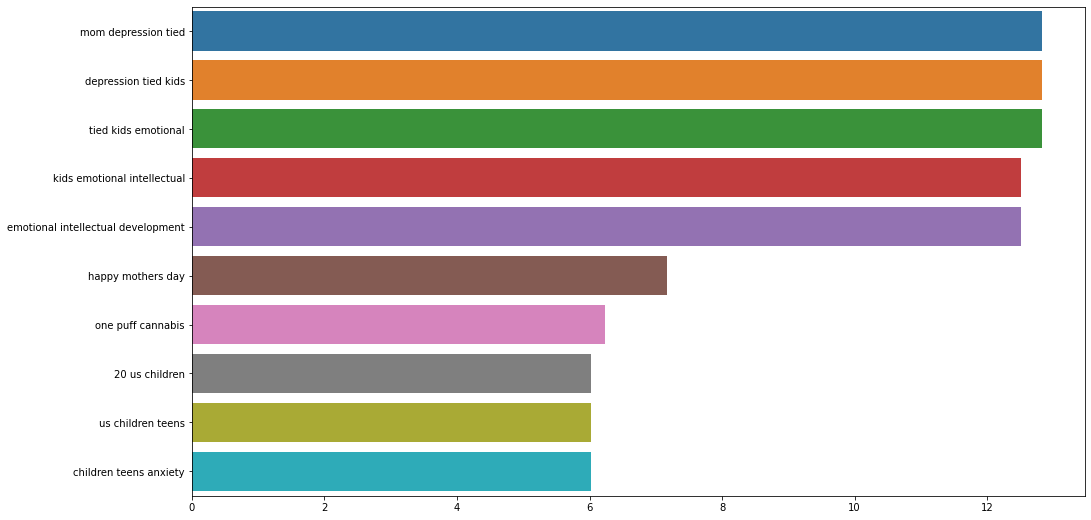

In [46]:
plt.figure(figsize = (16,9))
frequent_word_tri = get_top_text_ngrams(tweets.messagenew,10,3)
frequent_word_tri = dict(frequent_word_tri)
sns.barplot(x=list(frequent_word_tri.values()),y=list(frequent_word_tri.keys()))

## Models Instantiation and function definition for model fitting, prediction and classification

In [47]:
#Train_test split library
from sklearn.model_selection import train_test_split

#Model Instatiation
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

# prepare models
models = []
models.append(('NB', MultinomialNB()))
models.append(('LR', LogisticRegression()))
models.append(('RF',RandomForestClassifier()))
models.append(('DT', DecisionTreeClassifier(max_depth = 10)))


#Classification Reports
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, plot_confusion_matrix, roc_auc_score

In [48]:
from sklearn.model_selection import train_test_split

# function to split the data, fit and score models directly 
def fit_and_score(models, X,y):
    np.random.seed(42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify = y)
    print('\nTrain Size = {}\nTest Size = {}'.format(X_train.shape[0], X_test.shape[0]))
    model_scores = {}
    rocauc_scores = {}
    algols = {}
    y_tests = {}
    y_preds = {}
    for name, model in models:
        #fit the model
        m = model.fit(X_train, y_train)
        
        #append the trained model
        algols[name] = m
        
        #append the test set 
        y_tests[name] = y_test
        
        #Testing model to get predictions
        y_pred = model.predict(X_test)
        #append the predictions/outputs
        y_preds[name] = y_pred
        
        #append the score of the model
        model_scores[name] = model.score(X_test, y_test)
        rocauc_scores[name] = roc_auc_score(y_test, y_pred)
        
        #generate model scores
        print('rocauc', rocauc_scores[name])
        print('Accuracy Score for {} is {}\n'.format (name, model_scores[name]), '\t'*4, 'Details', '\n', '\t'*3, '=================')
        
        print(classification_report(y_test, y_pred, target_names = ['Not-Depresssed (0)', 'Depresssed(1)']))
        
        
        #Print Confusion Matrix
        title = 'Confusion Matrix of ' + name 
        ax = plot_confusion_matrix(model, X_test, y_test, display_labels = ['Not-Depresssed (0)', 'Depresssed(1)'], values_format = '.0f', cmap = 'viridis')
        plt.title(title)
        #plt.savefig(out + title + '.png')
        plt.show()
        print('\n'*3)
        
    return model_scores, algols, y_preds, y_tests, rocauc_scores
        

## Feature Extraction

The preprocessed words need to be encoded as integers or floating point values for use as input to a machine learning algorithm, this process is feature extraction (Vectorization). We will be examining two approaches to extract features from the tweet messages in the dataset

1. **Bag-of-Words Model (CountVectorizer)**

A simple and effective model for thinking about text documents in machine learning is called the Bag-of-Words Model, or BoW. 

The model is simple in that it throws away all of the order information in the words and focuses on the occurrence of words in a document by assigning each word a unique number. The value in each position in the vector could be filled with a count or frequency of each word in the encoded document. 

An encoded vector is returned with a length of the entire vocabulary and an integer count for the number of times each word appeared in the document.

2. **Word Counts with TfidfVectorizer (Term Frequency – Inverse Document Frequency)**

An alternative is to calculate word frequencies is called TF-IDF where frequencies are the components of the resulting scores assigned to each word. Frequency scores highlight words that are more interesting, e.g. frequent in not just a statement but across statements.

- Term Frequency: This summarizes how often a given word appears within a document.
- Inverse Document Frequency: This downscales words that appear a lot across documents. [ref](https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/)

In the dataset, there are: 
10314 tweets 
2308 generated features

Train Size = 7735
Test Size = 2579
rocauc 0.979341537132988
Accuracy Score for NB is 0.9755719271035285
 				 Details 
                    precision    recall  f1-score   support

Not-Depresssed (0)       1.00      0.97      0.98      2000
     Depresssed(1)       0.91      0.99      0.95       579

          accuracy                           0.98      2579
         macro avg       0.95      0.98      0.97      2579
      weighted avg       0.98      0.98      0.98      2579



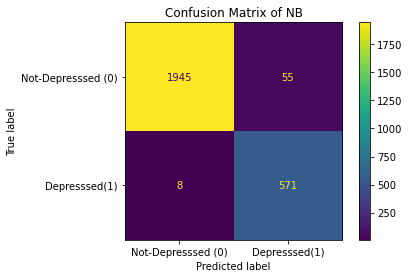





rocauc 0.9801381692573403
Accuracy Score for LR is 0.9910818146568438
 				 Details 
                    precision    recall  f1-score   support

Not-Depresssed (0)       0.99      1.00      0.99      2000
     Depresssed(1)       1.00      0.96      0.98       579

          accuracy                           0.99      2579
         macro avg       0.99      0.98      0.99      2579
      weighted avg       0.99      0.99      0.99      2579



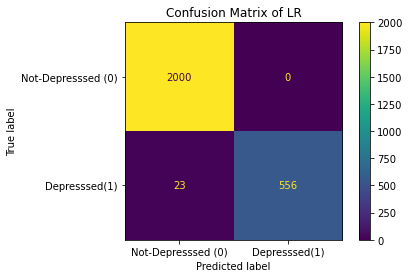





rocauc 0.9861601899827288
Accuracy Score for RF is 0.9918573090345095
 				 Details 
                    precision    recall  f1-score   support

Not-Depresssed (0)       0.99      1.00      0.99      2000
     Depresssed(1)       0.99      0.98      0.98       579

          accuracy                           0.99      2579
         macro avg       0.99      0.99      0.99      2579
      weighted avg       0.99      0.99      0.99      2579



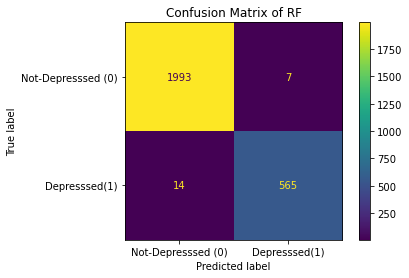





rocauc 0.9905008635578584
Accuracy Score for DT is 0.9957347809228383
 				 Details 
                    precision    recall  f1-score   support

Not-Depresssed (0)       0.99      1.00      1.00      2000
     Depresssed(1)       1.00      0.98      0.99       579

          accuracy                           1.00      2579
         macro avg       1.00      0.99      0.99      2579
      weighted avg       1.00      1.00      1.00      2579



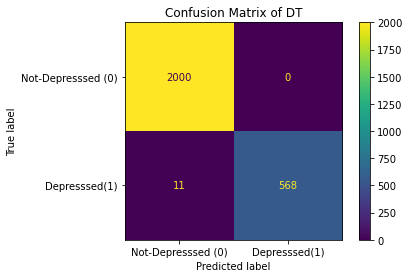

In [49]:
### Feature Extraction with TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

C_Vec = CountVectorizer(ngram_range=(1, 1), binary=False, decode_error='strict', lowercase=True, max_df=1.0, min_df=5, stop_words='english', strip_accents='unicode')
X = C_Vec.fit_transform(tweets.messagenew)
y = tweets.label
fn = C_Vec.get_feature_names()
print('In the dataset, there are: \n{} tweets \n{} generated features\n========='.format(X.shape[0], X.shape[1]))


#model_score
M_score_C_Vec = fit_and_score(models, X,y)


In the dataset, there are: 
10314 tweets 
2308 Features

Train Size = 7735
Test Size = 2579
rocauc 0.9049628670120898
Accuracy Score for NB is 0.9534703373400543
 				 Details 
                    precision    recall  f1-score   support

Not-Depresssed (0)       0.95      0.99      0.97      2000
     Depresssed(1)       0.97      0.82      0.89       579

          accuracy                           0.95      2579
         macro avg       0.96      0.90      0.93      2579
      weighted avg       0.95      0.95      0.95      2579



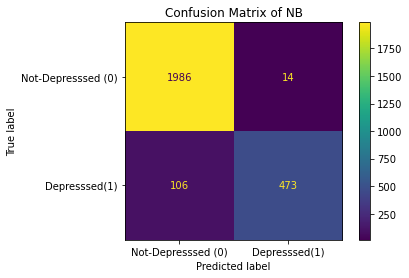





rocauc 0.9689119170984456
Accuracy Score for LR is 0.9860411012020163
 				 Details 
                    precision    recall  f1-score   support

Not-Depresssed (0)       0.98      1.00      0.99      2000
     Depresssed(1)       1.00      0.94      0.97       579

          accuracy                           0.99      2579
         macro avg       0.99      0.97      0.98      2579
      weighted avg       0.99      0.99      0.99      2579



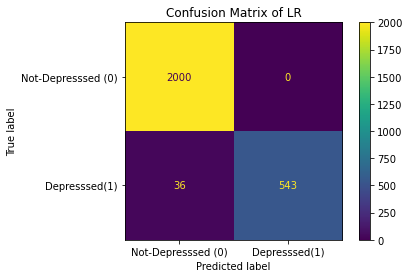





rocauc 0.9859330742659759
Accuracy Score for RF is 0.9934082977898411
 				 Details 
                    precision    recall  f1-score   support

Not-Depresssed (0)       0.99      1.00      1.00      2000
     Depresssed(1)       1.00      0.97      0.99       579

          accuracy                           0.99      2579
         macro avg       1.00      0.99      0.99      2579
      weighted avg       0.99      0.99      0.99      2579



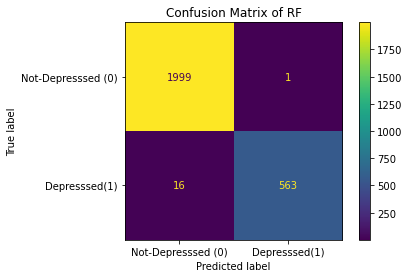





rocauc 0.9905008635578584
Accuracy Score for DT is 0.9957347809228383
 				 Details 
                    precision    recall  f1-score   support

Not-Depresssed (0)       0.99      1.00      1.00      2000
     Depresssed(1)       1.00      0.98      0.99       579

          accuracy                           1.00      2579
         macro avg       1.00      0.99      0.99      2579
      weighted avg       1.00      1.00      1.00      2579



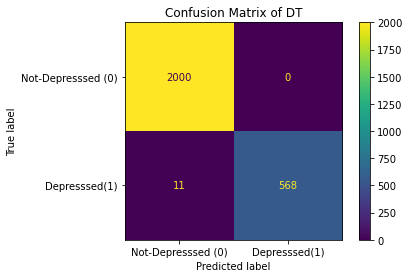

In [50]:
T_Vec = TfidfVectorizer(ngram_range=(1, 1), binary=False, decode_error='strict', lowercase=True, max_df=1.0, max_features=10000, min_df=5, stop_words='english', strip_accents='unicode')
X = T_Vec.fit_transform(tweets.messagenew)
y = tweets.label
fn_T = T_Vec.get_feature_names()
print('In the dataset, there are: \n{} tweets \n{} Features\n========='.format(X.shape[0], X.shape[1]))


M_score_T_Vec = fit_and_score(models, X,y)
#model_score

In [51]:
scores = {"Accuracy Score BOW": M_score_C_Vec[0], "Accuracy Score TDFIF": M_score_T_Vec[0], "ROC_AUC Score BOW": M_score_C_Vec[4], "ROC_AUC Score TDFIF": M_score_T_Vec[4]}
scores_frame = pd.DataFrame(scores)
scores_frame

,Accuracy Score BOW,Accuracy Score TDFIF,ROC_AUC Score BOW,ROC_AUC Score TDFIF
NB,0.975572,0.953470,0.979342,0.904963
LR,0.991082,0.986041,0.980138,0.968912
RF,0.991857,0.993408,0.986160,0.985933
DT,0.995735,0.995735,0.990501,0.990501


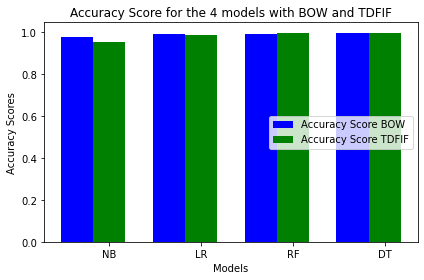

In [52]:
# data to plot
label = ["Accuracy Score BOW", "Accuracy Score TDFIF"]
n_models = np.arange(len(scores_frame.index))
bow = scores_frame["Accuracy Score BOW"]
tdif = scores_frame["Accuracy Score TDFIF"]

# create plot
fig, ax = plt.subplots()
bar_width = 0.35

ax = plt.bar(n_models, bow, bar_width, color='b', label = label[0])
ax1 = plt.bar(n_models + bar_width, tdif, bar_width, color='g', label = label[1])

plt.xlabel('Models')
plt.ylabel('Accuracy Scores')
plt.title("Accuracy Score for the 4 models with BOW and TDFIF")
plt.xticks(n_models + bar_width, scores_frame.index)
plt.legend(loc='right')

plt.tight_layout()
plt.show()

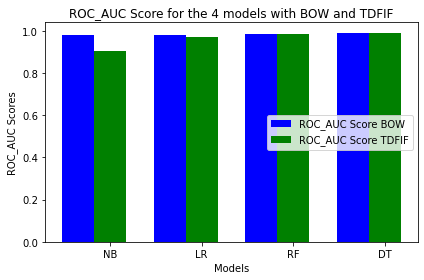

In [53]:
# data to plot
label = ["ROC_AUC Score BOW", "ROC_AUC Score TDFIF"]
n_models = np.arange(len(scores_frame.index))
bow = scores_frame["ROC_AUC Score BOW"]
tdif = scores_frame["ROC_AUC Score TDFIF"]

# create plot
fig, ax = plt.subplots()
bar_width = 0.35

ax = plt.bar(n_models, bow, bar_width, color='b', label = label[0])
ax1 = plt.bar(n_models + bar_width, tdif, bar_width, color='g', label = label[1])

plt.xlabel('Models')
plt.ylabel('ROC_AUC Scores')
plt.title("ROC_AUC Score for the 4 models with BOW and TDFIF")
plt.xticks(n_models + bar_width, scores_frame.index)
plt.legend(loc='right')

plt.tight_layout()
plt.show()

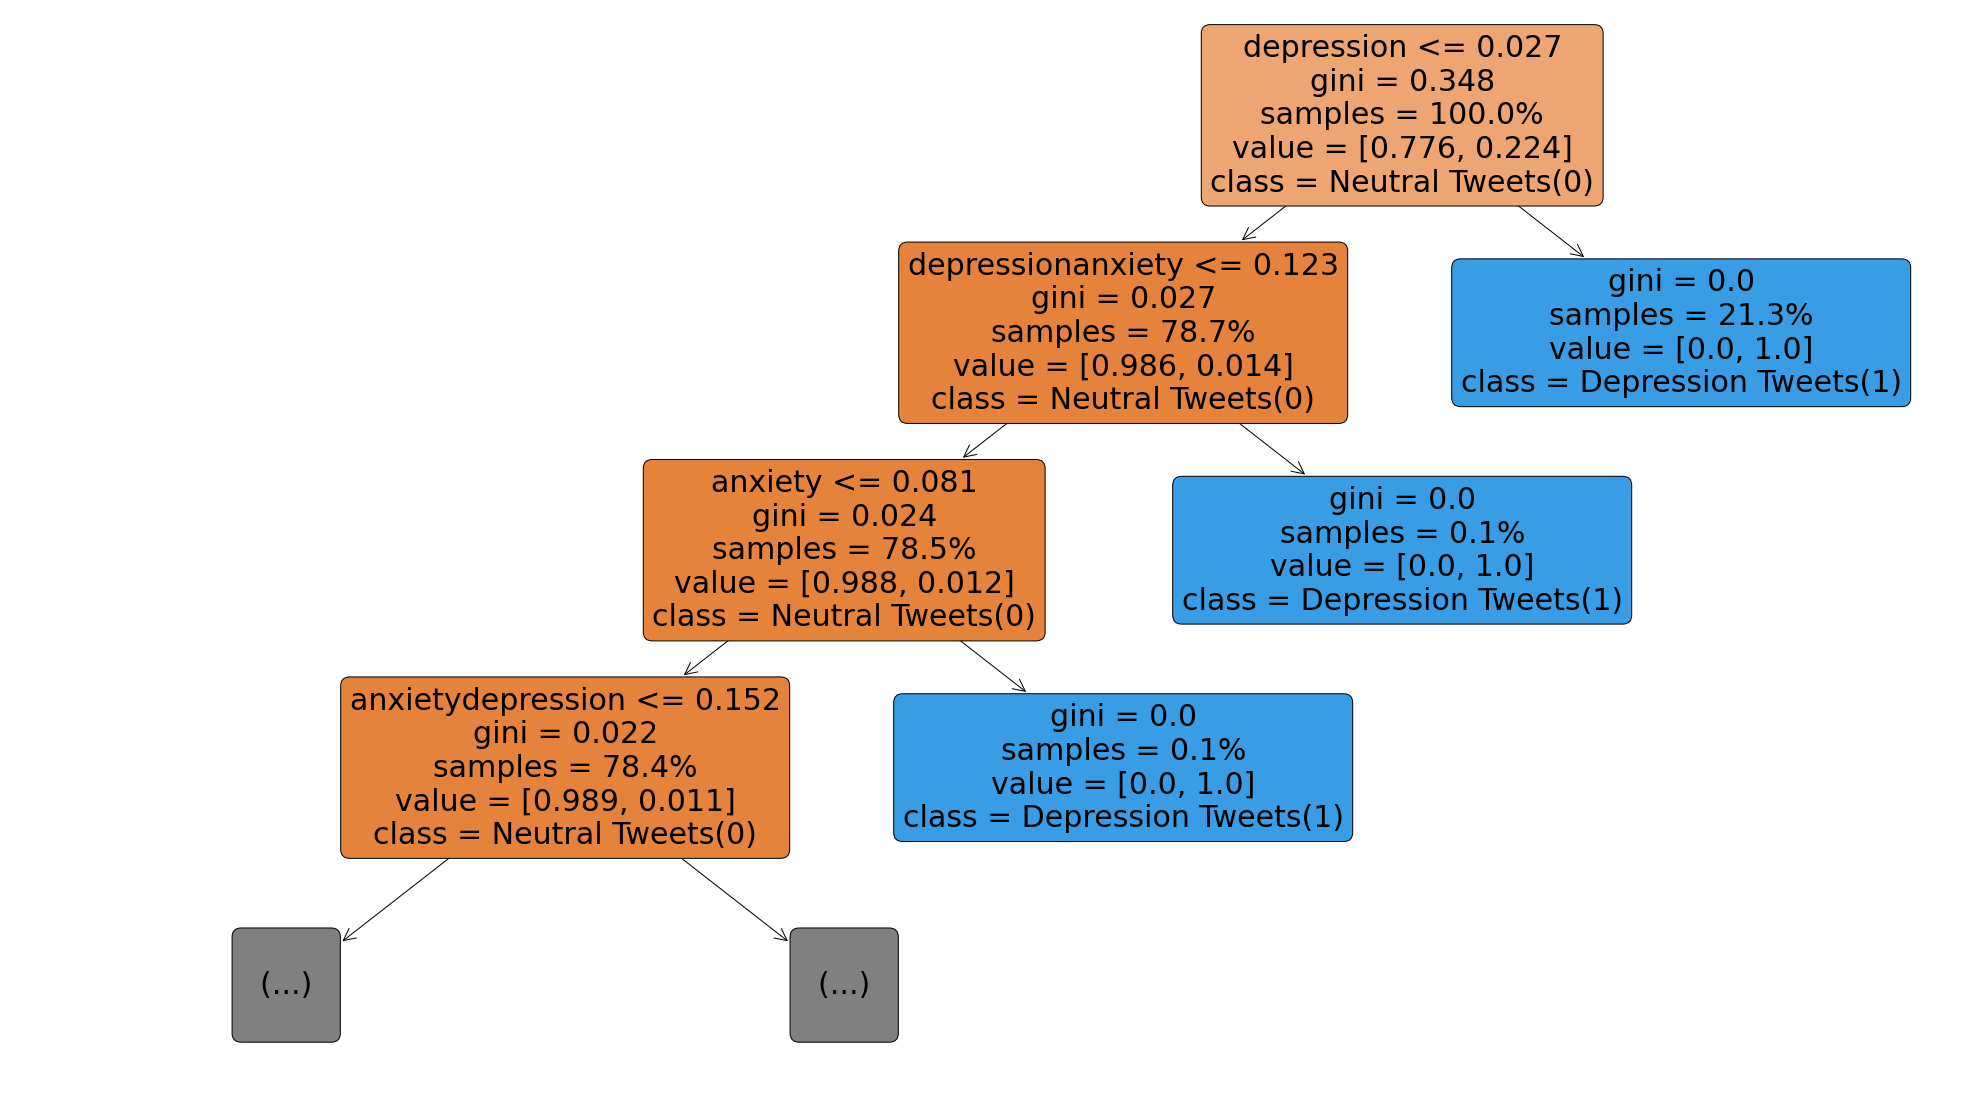

In [54]:
#Feature Analysis with decision tree classifier implemented in the model using BOW

plt.figure(figsize = (35,20))
a = plot_tree(M_score_C_Vec[1]['DT'], max_depth = 3, feature_names = fn, class_names = lb, proportion = True, filled = True, rounded = True, rotate = True, fontsize = 30)

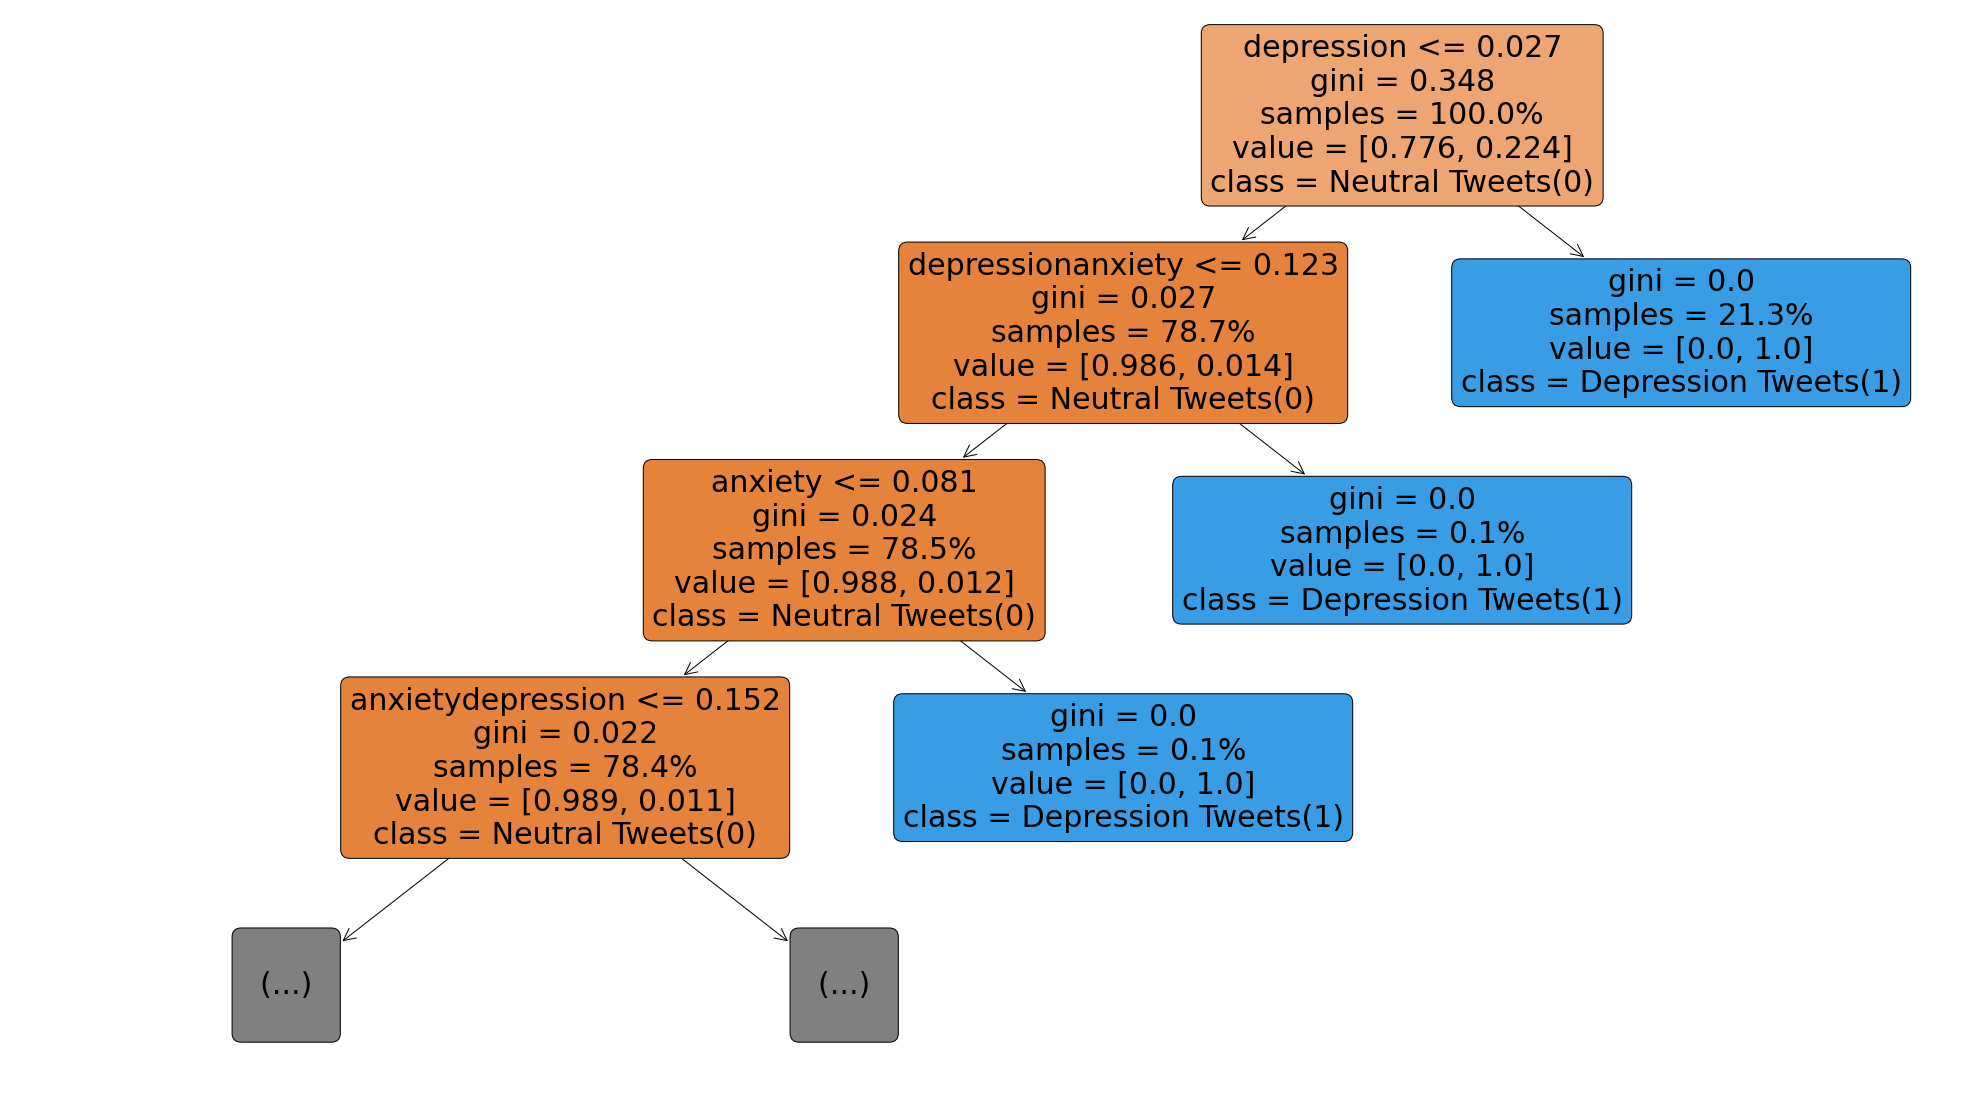

In [55]:
#Feature Analysis with decision tree classifier implemented in the model using TFIDF

plt.figure(figsize = (35,20))
a = plot_tree(M_score_T_Vec[1]['DT'], max_depth = 3, feature_names = fn_T, class_names = lb, proportion = True, filled = True, rounded = True, fontsize = 30)

As explained [here](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/) that decision trees algorithms like C4.5, C5.0, CART, and Random Forest often perform well on imbalanced datasets because the splitting rules look at the class variable used in the creation of the trees thereby forcing both classes to be addressed.

The Attribute Selection Measures(ASM) of the Decision tree shows that the best attributes constitutes words like depression, anxietydepression, brain, mentalhealthmatters, struggled etc 

In [57]:
X_train, X_test, y_train, y_test = train_test_split(tweets['messagenew'], tweets.label, test_size = 0.25, random_state = 42)

y_pred_C = list((M_score_C_Vec[2]['DT']))
y_pred_T = list((M_score_T_Vec[2]['DT']))

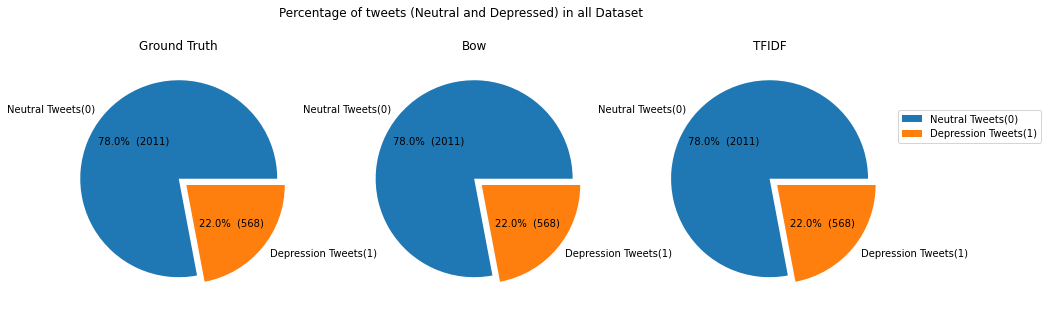

In [58]:
explode = (0,0.1)
fig, (ax, ax0, ax1) = plt.subplots(1,3,figsize=(15,5))
fig.suptitle('Percentage of tweets (Neutral and Depressed) in all Dataset')

ax.pie(list(totalnegpos(y_test)), explode = explode, labels = lb, autopct=make_autopct(list(totalnegpos(y_test))))
ax.set_title('Ground Truth')

ax0.pie(list(totalnegpos(y_pred_C)), explode = explode, labels = lb, autopct=make_autopct(list(totalnegpos(y_pred_C))))
ax0.set_title('Bow')

ax1.pie(list(totalnegpos(y_pred_T)), explode = explode, labels = lb, autopct=make_autopct(list(totalnegpos(y_pred_T))))
ax1.set_title('TFIDF')

plt.legend(loc='best',bbox_to_anchor=(1,0.8))
plt.show()


The depression tweets has the least number of data entries with 22%, and the neutral tweets has the most data with 8,000 entries. 

## Imbalanced Learning
The class imbalance problem typically occurs when, in a classification problem, there are many more instances of one class than the other. In such cases, standard classifiers tend to be overwhelmed by the large classes and ignore the small ones.